# Задача

В рамках данной задачи предстоит научиться получать наилучшее приближение $\sigma\in\mathbb{C}^n$ истинного квантового состояния $\rho\in\mathbb{C}^n$ по некоторой обучающей выборке $X_{train}=\{E_m,y_m\}_{m=0}^{N}$, где $E_m$ - некоторая матрица (называемая оператор, проектор), $y_m$ - некоторое наблюдение (проекция истинного состояния $\rho$ на этот оператор). 

В качестве оптимизируемого функционала предлагается минимизировать следующую функцию:
$$min_\sigma[f(\sigma)=\Sigma_m(Tr(E_m\sigma)-Tr(E_m\rho))^2=\Sigma_m(Tr(E_m\sigma)-y_m)^2]$$
$$\sigma\geq0,Tr(\sigma)=1$$
гдe $\sigma\geq0$ означает положительную полуопределённость обучаемой матрицы $\sigma$ 

# Решение

Поскольку матрица $\sigma$ - положительно полуопределённая, сделаем разложение Холецкого: $\sigma=M^*M$. 

Тогда 
$$Tr(\sigma)=Tr(M^*M)=\Sigma_{a_m\in M} a_m^*a_m=\Sigma_{a_m\in M} |a_m|^2$$

Поскольку для любой положительно полуопределённой матрицы существует разложение Холецкого, и, наоборот, для любой матрицы $M\in\mathbb{C}^n$ матрица $M^*M$ является положительно полуопределённой, мы можем переписать оптимизационную задачу в виде

$$min_M[f(M)=\Sigma_m(Tr(E_mM^*M)-y_m)^2]$$
$$Tr(M^*M)=\Sigma_{a_m\in M}|a_m|^2=1$$

Эту задачу можно было бы решать обычным методом множителей Лагранжа, но можно просто перенормировать $M$ на $\sqrt{Tr(M^*M)}$. Тогда задача сведётся к задаче безусловной оптимизации

$$min_M[f(M)=\Sigma_m(Tr(E_m\frac{M^*M}{Tr(M^*M)})-y_m)^2=\Sigma_m(Tr(E_m\frac{M^*M}{\Sigma_{a_m\in M}|a_m|^2})-y_m)^2]$$

In [1]:
import qutip
import numpy as np
import simulator as sim

from scipy.linalg import sqrtm
from scipy.optimize import minimize

### Генерация датасета

In [2]:
def generate_dataset(target_state, n_projectors, n_measurements, shuffle=True):
    dim = target_state.shape[0]
    X_train = np.array([sim.randomPureState(dim) for _ in range(n_projectors)])
    
    y_train = []
    for projector in X_train:
        ones, zeroes = sim.measure(n_measurements, target_state, projector)
        y_train.append(ones / n_measurements)
    y_train = np.array(y_train)
    
    indices = np.arange(n_projectors)
    if shuffle: np.random.shuffle(indices)
        
    return X_train[indices], y_train[indices]

In [3]:
n_qubits = 1
dim = 2 ** n_qubits
target_state = sim.randomPureState(dim)

X_train, y_train = generate_dataset(target_state, 10, 100)

### Вспомогательные функции

In [4]:
def fidelity(state_1, state_2):
    state_1_sqrt = sqrtm(state_1)
    F = np.dot(np.dot(state_1_sqrt, state_2), state_1_sqrt)
    return (np.trace(sqrtm(F)) ** 2).real

def to_density(M):
    state = M.dot(M.T.conj())
    norm = np.trace(state).real.sum()
    return state / norm

In [5]:
def to_realvector(z):
    z = z.reshape(-1)                       # complex matrix n * n -> complex vector of length n ** 2
    return np.concatenate((z.real, z.imag)) # complex of length n ** 2 -> real vector of length 2 * (n ** 2)

def to_complexmatrix(z): 
    half = len(z)//2
    z = z[:half] + 1j * z[half:]            # real vector of length 2 * (n ** 2) -> complex of length n ** 2
    n = np.sqrt(half).astype(np.int)
    return z.reshape(n, n)                  # complex of length n ** 2 -> complex matrix n * n

### Оптимизируемый функционал

In [6]:
def loss(M, X_train, y_train):
    pred_state = to_density(M)
    pred = np.trace(np.einsum('bij,jk->bik', X_train, pred_state), axis1=1, axis2=2).real
    return np.mean((pred - y_train) ** 2)

### Оптимизация

In [7]:
M = sim.randomMixedState(dim)
init_state = to_density(M)

print('init fidelity:\t', fidelity(target_state, init_state))
print('init loss:\t', loss(M, X_train, y_train))

init fidelity:	 0.6717361907757574
init loss:	 0.0959308624970772


In [8]:
res = minimize(
    lambda z: loss(to_complexmatrix(z), X_train, y_train), 
    x0=to_realvector(M), 
    method='BFGS'
)

In [9]:
M = to_complexmatrix(res.x)
pred_state = to_density(M)

print('final fidelity:\t', fidelity(target_state, pred_state))
print('final loss:\t', loss(M, X_train, y_train))

final fidelity:	 0.9808967503330298
final loss:	 0.0008869683948849426


### Визуализация состояний на Сфере Блоха

In [10]:
def density_to_bloch(density_matrix):
    x = 2 * density_matrix[0, 1].real
    y = 2 * density_matrix[1, 0].imag
    z = (density_matrix[0, 0] - density_matrix[1, 1]).real
    return np.array([x, y, z])

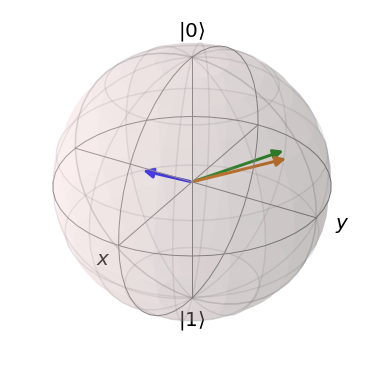

In [11]:
b = qutip.Bloch()
b.add_vectors(list(map(density_to_bloch, [target_state, pred_state, init_state])))
b.show()